In [209]:
# Run in python console
import nltk; nltk.download('stopwords')
import spacy

import re
import os
import numpy as np
import pandas as pd
import zipfile

from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
import en_core_web_sm

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from langdetect import detect

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


import shutil
import glob
from tika import parser

from yellowbrick.features import rank2d
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Importing data into DataFrame

In [10]:
def create_data_frame(csv_path):
    df = pd.read_csv(csv_path)
    return df

In [11]:
path = '../data/new-york-city-airbnb-open-data/'
listings_csv = os.path.join(path,'listings.csv')

listings_df = create_data_frame(listings_csv)

/home/ec2-user/anaconda3/envs/capst_kernel/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## Exploring DataFrames

In [12]:
# Looking for text in the data
listings_df.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 106, dtype: object

In [13]:
def predict_lang(x):
    lang=''
    txt_len=len(x)
    if txt_len>50:
        try:
            lang=detect(x)
        except Exception as e:
            lang=''
    return lang

In [14]:
listings_df['content'] = listings_df['name'] + listings_df['summary']
listings_df.dropna(subset=['content'], how='any', axis=0, inplace=True)
listings_df['content_lang'] = listings_df.content.apply(lambda x: predict_lang(x))

In [48]:
# getting only text in English
listings_df=listings_df[listings_df.content_lang=='en']

In [50]:
listings_df.shape

(47684, 108)

In [17]:
def generate_list_content(df):
#     df['content'] = df['name'] + df['summary']
#     df['content'] = df['content'].replace(np.nan, '', regex=True)
    
    # Convert to list
    data = df['content'].values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    
    
    return data

In [18]:
lst_texts = generate_list_content(listings_df)
# listings_df['content']

In [19]:
len(lst_texts)

47684

## Tokenize words and clean up text

In [20]:
# here we are tokenizing each document.
def content_to_words(lst_texts):
    for text in lst_texts:
        yield(gensim.utils.simple_preprocess(str(text), deacc=True))
        
# data_words is a list where each element is the tokenized document
tokenized_content = list(content_to_words(lst_texts))

## Create bigram and trigrams

In [21]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tokenized_content, min_count=10, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tokenized_content], threshold=100)  


# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

## Remove Stopwords, Make Bigrams and Lemmatize

In [22]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(tokenized_content):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in tokenized_content]

def make_bigrams(tokenized_content):
    return [bigram_mod[doc] for doc in tokenized_content]

def make_trigrams(tokenized_content):
    return [trigram_mod[bigram_mod[doc]] for doc in tokenized_content]

def lemmatization(tokenized_content, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in tokenized_content:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

In [23]:
# Remove Stop Words
tokenized_content_nostops = remove_stopwords(tokenized_content)

# Form Bigrams
tokenized_content_bigrams = make_bigrams(tokenized_content_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
tokenized_content_lemmatized = lemmatization(tokenized_content_bigrams, 
                                             allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## Create the Dictionary and Corpus needed for Topic Modeling

In [24]:
# Create Dictionary:
# Mapping from word IDs to words. 
# It is used to determine the vocabulary size, as well as for debugging and topic printing.
id2word = corpora.Dictionary(tokenized_content_lemmatized)
# print(len(id2word)) # corpus has 14118 unique tokens

# Term Document Frequency
# Convert document (a list of words) into the bag-of-words format = list of (token_id, token_count) 2-tuples.
# Word with their corresponding id
corpus = [id2word.doc2bow(text) for text in tokenized_content_lemmatized]

# View
# print(corpus[:1])

## Build list of topic models

In [25]:
def build_topics(num_topics):
    list_models=[]
    for n in num_topics:
        topic_name = 'lda_model_' + str(n)
        topic_name = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, 
                                                     num_topics=n, random_state=100, 
                                                     update_every=1, chunksize=100, 
                                                     passes=10, alpha='auto', 
                                                     per_word_topics=True)
        list_models.append(topic_name)
    return list_models

num_topics = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
models = build_topics(num_topics)

## Compute Model Perplexity and Coherence Score for all models

In [26]:
def calc_perplexity_coherence(models):
    list_perplexity = []
    list_coherence = []
    
    for model in models:
        list_perplexity.append(model.log_perplexity(corpus))
        coherence_model_lda = CoherenceModel(model=model, texts=tokenized_content_lemmatized, 
                                             dictionary=id2word, coherence='c_v')
        list_coherence.append(coherence_model_lda.get_coherence())
    return list_perplexity, list_coherence

x = calc_perplexity_coherence(models)      

In [27]:
df_metrics = pd.DataFrame(list(x)).transpose()
df_metrics.columns = ['Perplexity','Coherence']
df_metrics['Number of topics'] = num_topics
df_metrics

,Perplexity,Coherence,Number of topics
0,-6.572732,0.473601,2
1,-6.552930,0.538393,3
2,-6.574615,0.521252,4
3,-6.620297,0.487307,5
4,-6.645996,0.405120,6
5,-6.681094,0.430134,7
6,-6.726204,0.394624,8
7,-6.777265,0.395753,9
8,-6.869783,0.388227,10
9,-7.031487,0.366011,11


## Graphic of number of Topics and Perplexity

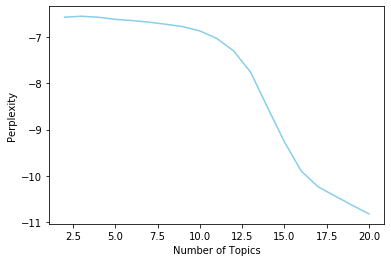

In [28]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Perplexity', data=df_metrics, color='skyblue')
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.show()

## Graphic of number of Topics and Coherence

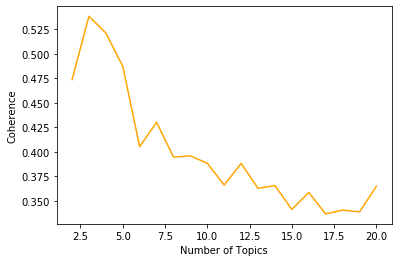

In [29]:
# Perplexity needs to be as low as possible 
plt.plot( 'Number of topics', 'Coherence', data=df_metrics, color='orange')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence")
plt.show()

## Most salient topic per file using results of Model of choice

In [30]:
# def format_topics_sentences(ldamodel=None, corpus=corpus, texts=lst_texts):
#     # Init output
#     sent_topics_df = pd.DataFrame()

#     # Get main topic in each document
#     for i, row_list in enumerate(ldamodel[corpus]):
#         row = row_list[0] if ldamodel.per_word_topics else row_list            
#         print(row)
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
#         # Get the Dominant topic, Perc Contribution and Keywords for each document
#         for j, (topic_num, prop_topic) in enumerate(row):
#             if j == 0:  # => dominant topic
#                 wp = ldamodel.show_topic(topic_num)
#                 topic_keywords = ", ".join([word for word, prop in wp])
#                 sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num) + 1, 
#                                                                   round(prop_topic,4), 
#                                                                   topic_keywords]), ignore_index=True)
#             else:
#                 break
#     sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

#     # Add original text to the end of the output
# #     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([listings_df,sent_topics_df], axis=1, sort=False)
#     return(sent_topics_df)

## DataFrame with scores of all topics

In [179]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=lst_texts):
    # Init output
    sent_topics_df = list()
#     listings_df.reset_index()
    
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        sent_topics_df.append(row)
        
    sent_topics_df = pd.DataFrame(sent_topics_df)
    sent_topics_df.columns = ['Dominant_Topic_1', 'Dominant_Topic_2', 'Dominant_Topic_3']
    sent_topics_df = pd.concat([listings_df['id'],sent_topics_df], axis=1, sort=False)
    
#     sent_topics_df.rename(columns={"id": "listing_id"},inplace=True)
    
#     sent_topics_df.set_index('listing_id',inplace=True)
    
    df_n_cols = sent_topics_df.shape[1]
    
    return sent_topics_df, df_n_cols

In [180]:
sent_topics_df, df_n_cols = format_topics_sentences(ldamodel=models[1], corpus=corpus, texts=lst_texts)

In [181]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3
0,2595,"(1, 0.69163835)","(0, 0.28562173)","(2, 0.022739904)"
1,3831,"(1, 0.7918562)","(0, 0.15195668)","(2, 0.05618707)"
2,5099,"(1, 0.52514637)","(0, 0.460814)","(2, 0.014039644)"
3,5178,"(1, 0.68388236)","(2, 0.17437664)","(0, 0.141741)"
4,5203,"(2, 0.52477676)","(1, 0.2639455)","(0, 0.21127775)"


In [182]:
for i in range(1,df_n_cols):
    col = 'score_dom_topic_' + str(i)
    sent_topics_df[col] = pd.DataFrame(sent_topics_df.iloc[:,i].tolist(), index=sent_topics_df.index)[1]

In [183]:
sent_topics_df.head()

,id,Dominant_Topic_1,Dominant_Topic_2,Dominant_Topic_3,score_dom_topic_1,score_dom_topic_2,score_dom_topic_3
0,2595,"(1, 0.69163835)","(0, 0.28562173)","(2, 0.022739904)",0.691638,0.285622,0.022740
1,3831,"(1, 0.7918562)","(0, 0.15195668)","(2, 0.05618707)",0.791856,0.151957,0.056187
2,5099,"(1, 0.52514637)","(0, 0.460814)","(2, 0.014039644)",0.525146,0.460814,0.014040
3,5178,"(1, 0.68388236)","(2, 0.17437664)","(0, 0.141741)",0.683882,0.174377,0.141741
4,5203,"(2, 0.52477676)","(1, 0.2639455)","(0, 0.21127775)",0.524777,0.263945,0.211278


In [184]:
cols_2_drop = ['Dominant_Topic_1', 'Dominant_Topic_2','Dominant_Topic_3']
sent_topics_df.drop(columns=cols_2_drop, inplace=True)

In [185]:
sent_topics_df.shape

(47684, 4)

### Visualize the topics

In [142]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(models[1], corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.133972  0.245869       1        1  44.600098
1     -0.181789 -0.222240       2        1  40.398598
2      0.315760 -0.023629       3        1  15.001300, topic_info=           Term          Freq         Total Category  logprob  loglift
89         stay  10808.000000  10808.000000  Default  30.0000  30.0000
49         room  29377.000000  29377.000000  Default  29.0000  29.0000
54         walk  16104.000000  16104.000000  Default  28.0000  28.0000
154  restaurant  13496.000000  13496.000000  Default  27.0000  27.0000
47       minute  12483.000000  12483.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
23        enjoy   1349.904175   4567.923828   Topic3  -4.9299   0.6780
438        work   1058.899902   2421.254883   Topic3  -5.1727   1.0700
42         feel   1108.845581   3159.645508   Topic3  -5.1266   0.8499
38         city   1164.871094   5472.611328   Topic3  -5.0773   0.3499
49         room   1151.060791  29377.375000   Topic3  -5.0893  -1.3425

[179 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1000      3  0.998957  accommodation
535       1  0.005364        amenity
535       2  0.994318        amenity
535       3  0.000335        amenity
33        1  0.499928      apartment
...     ...       ...            ...
180       3  0.740649           will
278       2  0.999733         window
438       2  0.562518           work
438       3  0.437376           work
725       3  0.999380          would

[210 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

## Concatenating the Dominant Topics with the rest of the Features for Regression

In [222]:
model_cols_df = pd.read_csv('../data/new-york-city-airbnb-open-data/model_columns_listings.csv',index_col = 0)

In [223]:
df_model = pd.merge(left=model_cols_df, right=sent_topics_df, how='left', on='id')

In [231]:
df_model = df_model.dropna()

## Split train - test sets

In [232]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_model.loc[:, df_model.columns != 'price'], 
                                                    df_model.price, test_size=0.2)

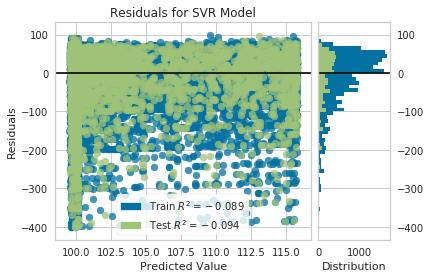

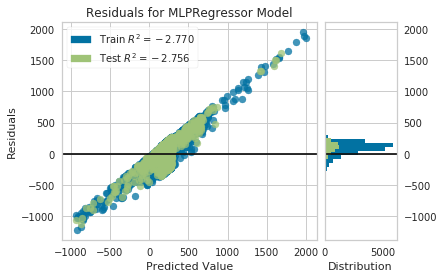

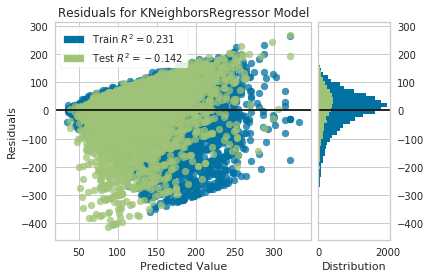

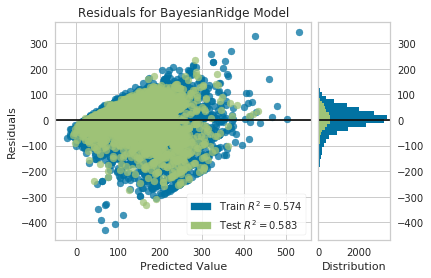

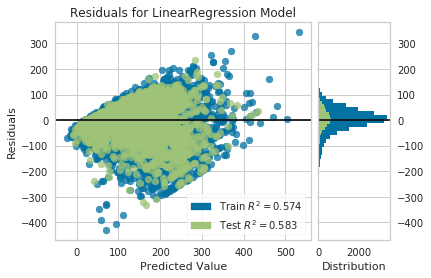

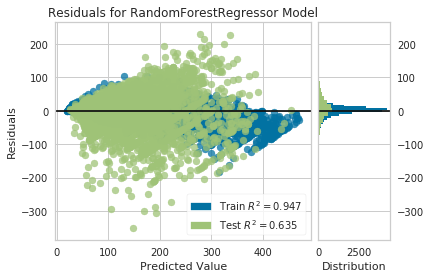

In [243]:
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from yellowbrick.features import FeatureImportances

regressors = {
    "support vector machine": SVR(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
    "random forest": RandomForestRegressor(),
}

for _, regressor in regressors.items():
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
    
    
# #     model = RandomForestRegressor()
# oz = ResidualsPlot(model)

# oz.fit(Xr_train, yr_train)
# oz.score(Xr_test, yr_test)
# _ = oz.show()